In [1]:
import sqlalchemy as sq
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import datetime as dt

In [12]:
dt.datetime.today() - dt.timedelta(days=2)

datetime.datetime(2021, 9, 12, 10, 18, 14, 562202)

In [2]:
engine = sq.create_engine('sqlite:///data/covid_db.sqlite')
cnx = engine.connect()

In [3]:
meta = sq.MetaData()

# Covid cases vs vaccination

I have an idea: can someone write a script to 
* compare current covid cases among countries as a function of vaccination rates. 
* Same for deaths/1 miliion population. 
* One of the parameters should be a timeline of vaccinations - vaccines tend to wane over time, we have a chance to figure out to what extent

In [4]:
df = pd.read_sql('covid_world',cnx)

In [5]:
df = df.astype({
    'date':'datetime64[ns]'
})

In [6]:
df['all_doses_vaccinated_per_million'] = (df['all_doses_vaccinated_per_hundred'] / 100) * 1000000

In [7]:
continents = ['Asia','Australia','Africa','Europe','South America', 'North America']

In [8]:
df_cont = pd.DataFrame()

In [9]:
for loc in continents:
    df_cont = df_cont.append(df[df['location'] == loc])
df_cont = df_cont.reset_index(drop=True)

In [10]:
smol_df = df[df['location'] == 'Israel']

In [17]:
def plotter(col1, col2, save=True):
    sns.lineplot(x='date',
                y=col1, 
                data = smol_df, color='b',label=col1
                )
    ax2 = plt.twinx()
    sns.lineplot(x='date',
                y=col2, 
                data = smol_df,
                ax=ax2, color='g', label=col2)
    plt.tight_layout()
    plt.legend()

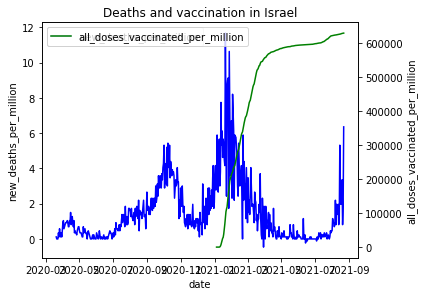

In [18]:
plotter(col1='new_deaths_per_million',col2='all_doses_vaccinated_per_million')
plt.title('Deaths and vaccination in Israel')
plt.savefig(f'deaths_vax.png', dpi=300, facecolor='white')

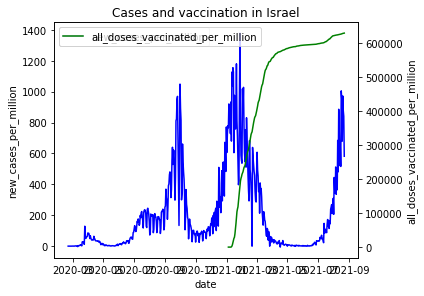

In [19]:
plotter(col1='new_cases_per_million',col2='all_doses_vaccinated_per_million')
plt.title('Cases and vaccination in Israel')
plt.savefig(f'cases_vax.png', dpi=300, facecolor='white')

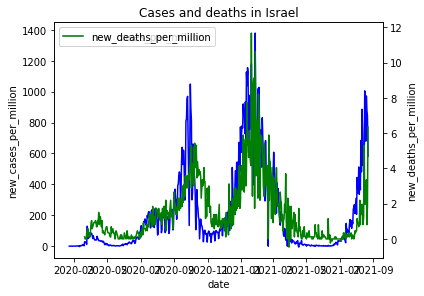

In [20]:
plotter(col1='new_cases_per_million',col2='new_deaths_per_million', save=False)
plt.title('Cases and deaths in Israel')
plt.savefig('cases_and_Deaths.png', dpi=300, facecolor='white')

---------------------------------

# CDC: By age and Sex

https://data.cdc.gov/NCHS/Provisional-COVID-19-Deaths-by-Sex-and-Age/9bhg-hcku/data

In [42]:
# get latest data
new_df = df[df['date'] == df['date'].max()]
new_df = new_df.sort_values('weekly_rolling_new_cases_per_100k', ascending=False)
top_3_array = new_df[['date','state','weekly_rolling_new_cases_per_100k']].iloc[:3,1].values
default_options = list(top_3_array)


In [47]:
default = ['Ohio','Texas'] + default_options + ['Texas']

In [50]:
tuple(default)

('Ohio', 'Texas', 'Florida', 'Louisiana', 'Mississippi', 'Texas')

In [51]:
list(dict.fromkeys(default))

['Ohio', 'Texas', 'Florida', 'Louisiana', 'Mississippi']

In [3]:
def check_states(df1, df2):
    states1 = df1['state'].unique()
    states2 = df2['state'].unique()
    
    for state in states1:
        if state not in states2:
            print(f"df2 doesn't have {state}")
            
    for state in states2:
        if state not in states1:
            print(f"df1 doesn't have {state}")

In [4]:
def cat_state(my_string):
    regions = {
        'northeast':['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 
                     'Rhode Island', 'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
        'midwest':['Illinois', 'Indiana', 'Michigan', 'Ohio', 
                   'Wisconsin', 'Iowa', 'Kansas', 'Minnesota', 'Missouri', 
                   'Nebraska', 'North Dakota','South Dakota'],
        'south':['Delaware', 'Florida', 'Georgia', 'Maryland',
                 'North Carolina', 'South Carolina', 'Virginia', 
                 'District of Columbia', 'West Virginia', 'Alabama', 
                 'Kentucky', 'Mississippi', 'Tennessee', 'Arkansas', 
                 'Louisiana', 'Oklahoma', 'Texas'],
        'west':['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada',
                'New Mexico', 'Utah', 'Wyoming', 'Alaska', 
                'California', 'Hawaii', 'Oregon', 'Washington']
    }

    for r in regions.keys():
        if my_string in regions[r]:
            return r

In [5]:
import pandas as pd
from sodapy import Socrata

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:

# Example authenticated client (needed for non-public datasets):
client = Socrata("data.cdc.gov",
                 app_token='hWgCpbEoGvuNOPwJqBPcONAb8',
                 username="pgate89@gmail.com",
                 password="U8#eu54oXNLe&6")

In [6]:
age_range = ['All Ages', 'Under 1 year', '0-17 years','18-29 years', 
       '30-39 years', '40-49 years', '50-64 years', '65-74 years', '75-84 years',
       '85 years and over']

In [7]:
# dictionaries by sodapy.
results = client.get("9bhg-hcku", year='2021', limit=5000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

results_df['start_date'] = pd.to_datetime(results_df['start_date'])
results_df['end_date'] = pd.to_datetime(results_df['end_date'])
results_df['data_as_of'] = pd.to_datetime(results_df['data_as_of'])

results_df = results_df.astype({
    'year':int,
    'covid_19_deaths':float,
    'total_deaths':float,
    'pneumonia_deaths':float,
    'pneumonia_and_covid_19_deaths':float,
    'influenza_deaths':float,
    'pneumonia_influenza_or_covid':float
})

In [156]:
df = results_df.copy().iloc[:,0:10]
# select dates of interest
df = df[df['end_date'] >= pd.to_datetime('07-31-2021')]
df = df[df['start_date']== pd.to_datetime('01-01-2021')]

df = df[df['age_group'].apply(lambda x: True if x in age_range else False)]
df = df[df['sex']=='All Sexes']

df['region'] = df['state'].map(cat_state)

df['perc_covid_deaths'] = df['covid_19_deaths'] / df['total_deaths'] * 100

In [139]:
usa = df[df['state']=='United States'].drop(['region','group'],axis=1)
states = df.dropna(subset=['region'])

Text(0.5, 1.0, 'Percent deaths in 2021 due to covid')

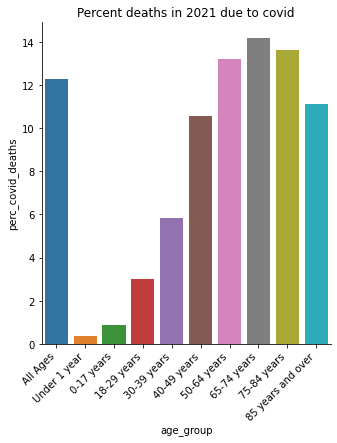

In [157]:
sns.catplot(x='age_group',y='perc_covid_deaths',data=usa, kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Percent deaths in 2021 due to covid')

# NYT data

In [5]:
engine = sq.create_engine("sqlite:///data/covid_db.sqlite")
cnx = engine.connect()

In [6]:
meta = sq.MetaData()
meta.reflect(bind=engine)

In [7]:
meta.tables.keys()

dict_keys(['covid_states', 'covid_world', 'vax_usa'])

In [8]:
usa_df = pd.read_csv(
    "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"
)
usa_vax = pd.read_csv('https://github.com/owid/covid-19-data/raw/master/public/data/vaccinations/us_state_vaccinations.csv').rename({'location':'state'}, axis=1)
usa_vax['state'] = usa_vax['state'].str.replace('New York State', 'New York')
usa_df2 = usa_df.merge(usa_vax, on=['date','state'])

In [10]:
usa_demos = pd.read_csv('covid_demos.csv')
usa_demos.columns = [col.replace(' ','_').replace('-','_').lower() for col in usa_demos.columns]
usa_demos['region'] = usa_demos['state'].apply(cat_state)
usa_demos['perc_covid_deaths'] = (usa_demos['covid_19_deaths'] / usa_demos['total_deaths']) * 100

In [12]:
state = 'Ohio'
times = usa_demos[(usa_demos['group'] == 'By Month') & (usa_demos['state'] != 'United States')]

times = times.astype({
    'year':int,
    'month':int
})

times = times.astype({
    'year':str,
    'month':str
})

times['month_year'] = times['month'] + '/' + times['year']
times['month_year'] = pd.to_datetime(times['month_year']).apply(lambda x: x.date())

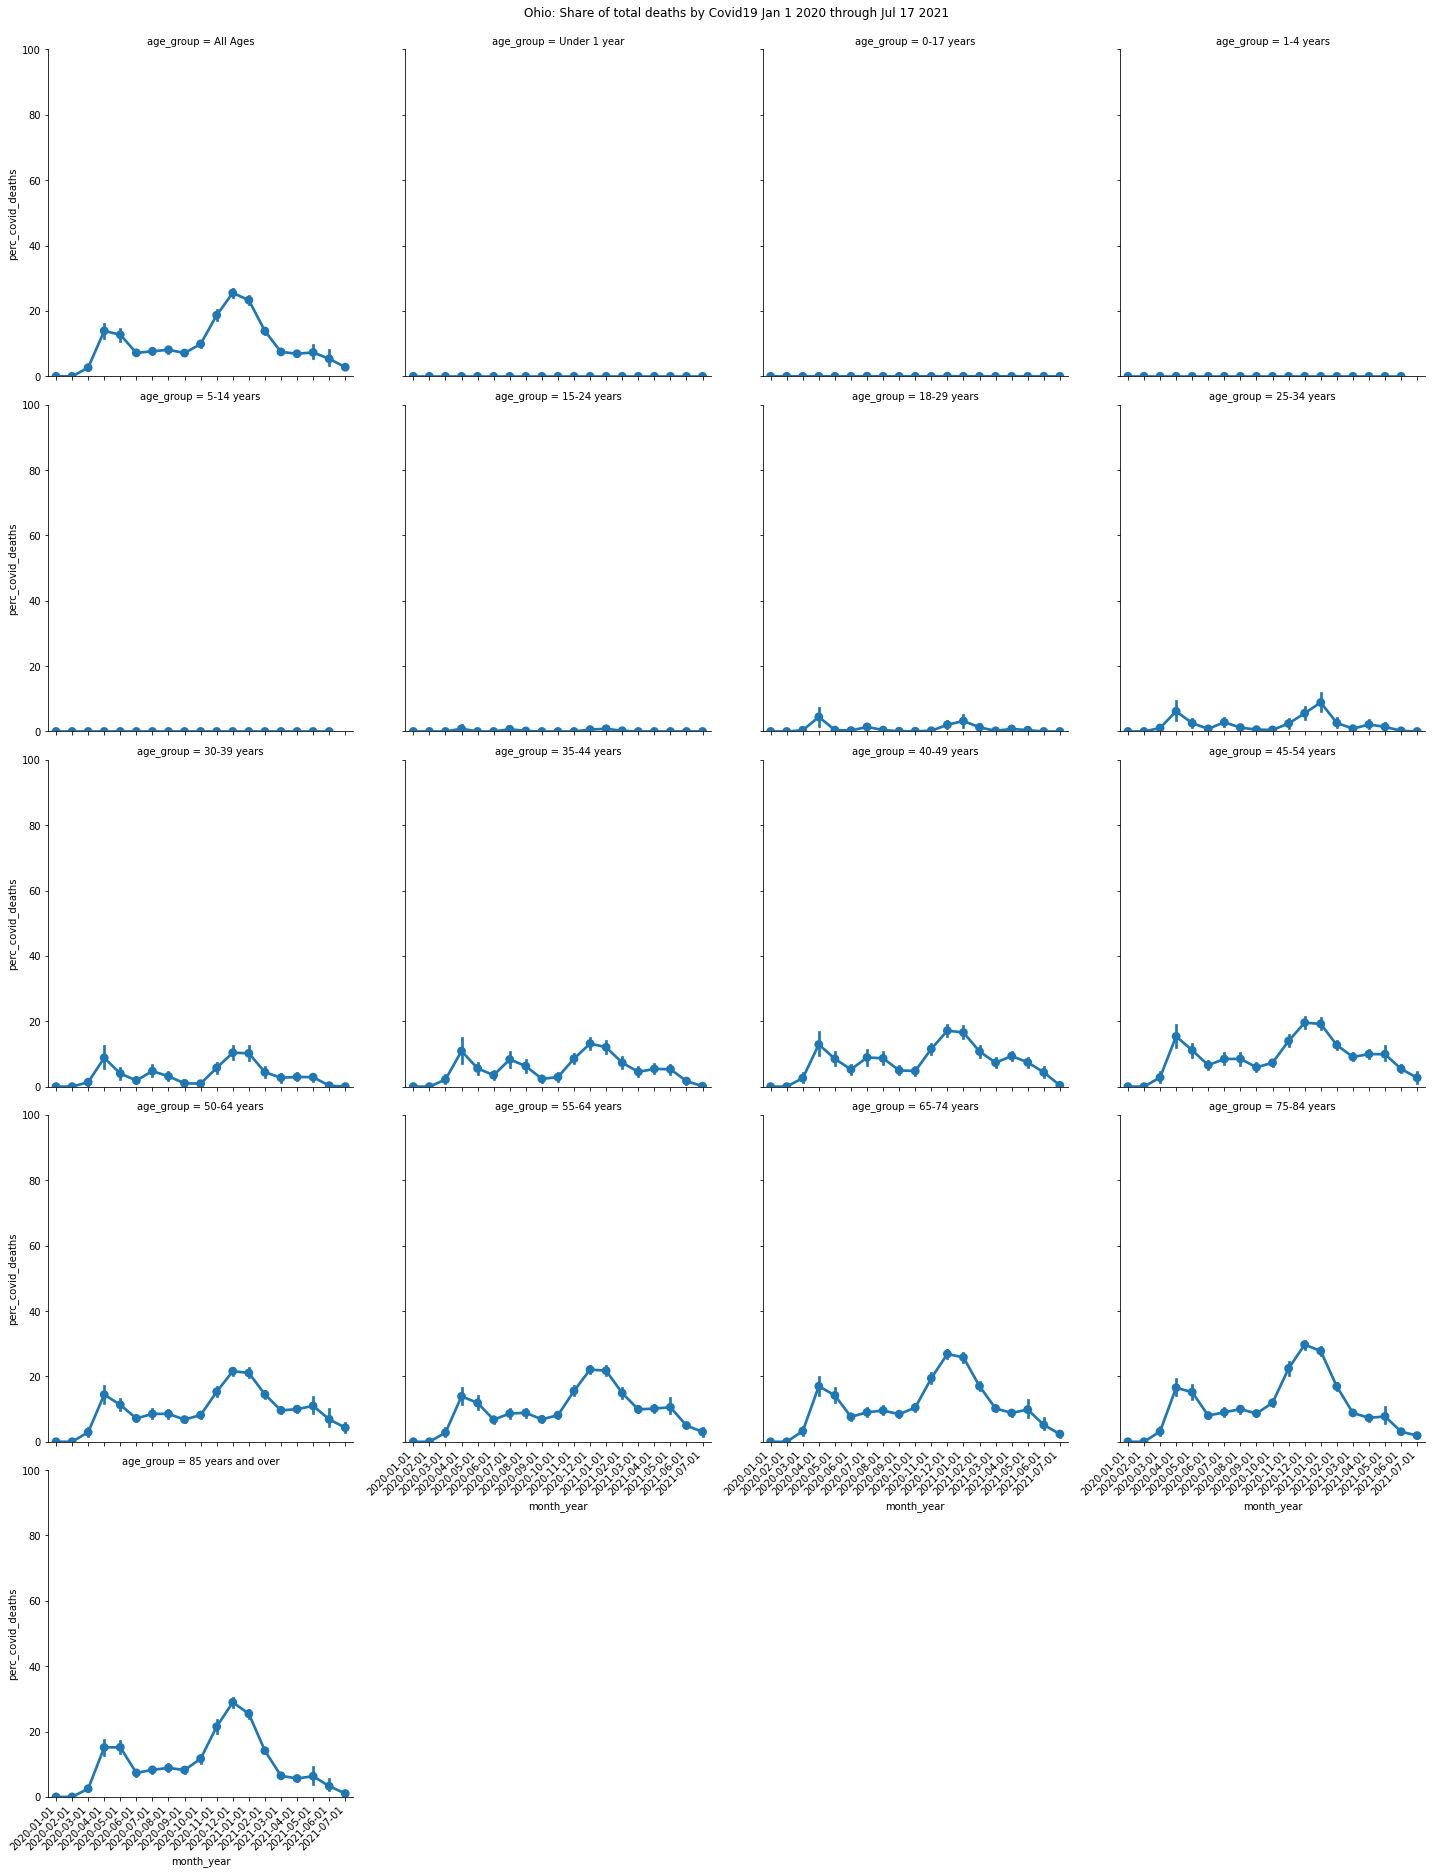

In [14]:
g = sns.catplot(x='month_year',y='perc_covid_deaths',data=times, kind='point', col='age_group',col_wrap = 4, )
g.set_xticklabels(rotation=45, horizontalalignment='right')
g.fig.suptitle(f'{state}: Share of total deaths by Covid19 Jan 1 2020 through Jul 17 2021', y = 1.01)
g.set(ylim=(0, 100))

In [16]:
g.savefig('age_deaths.png', dpi=300)